In [10]:
#Import librerie
import os
from pathlib import Path
import numpy as np
from PIL import Image
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.models.segmentation import fcn_resnet50

from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from matplotlib import colormaps
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import functional as TF

In [11]:
#Configurazioni
base_path = "/kaggle/input/d/awsaf49/coco-2017-dataset/coco2017"
train_img_dir = os.path.join(base_path, "train2017")
train_ann_file = os.path.join(base_path, "annotations/instances_train2017.json")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Dimensione del dataset
NUM_IMG=100

#Hyperparameters
SIZE=1024
IMG_SIZE = (1024, 1024)
BATCH_SIZE = 2
NUM_WORKERS = 4
LR = 4.4e-4
NUM_EPOCHS = 20

CHECKPOINT_DIR = "/kaggle/working/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

#Loss
criterion = nn.CrossEntropyLoss()

# Max batches per la validation
MAX_BATCHES = 500 

In [12]:
coco = COCO(train_ann_file)
cat_ids = sorted(coco.getCatIds()) 
cat2label = {cat_id: idx+1 for idx, cat_id in enumerate(cat_ids)}

NUM_CLASSES = len(cat_ids) + 1 
print("NUM_CLASSES (including background):", NUM_CLASSES)

loading annotations into memory...
Done (t=16.11s)
creating index...
index created!
NUM_CLASSES (including background): 81


In [13]:
#DatasetCustom
class COCOSegmentationDataset(Dataset):
    def __init__(self, img_dir, coco, cat2label, target_size=(SIZE,SIZE)):
        self.img_dir = img_dir
        self.coco = coco
        self.ids = coco.getImgIds()
        self.cat2label = cat2label
        self.target_size = target_size

    def _build_mask(self, anns, h, w):
        mask = np.zeros((h, w), dtype=np.uint8)
        anns = sorted(anns, key=lambda a: a["area"], reverse=True)
        for ann in anns:
            m = self.coco.annToMask(ann)
            label = self.cat2label[ann["category_id"]]
            mask[m > 0] = label
        return mask

    def _resize_(self, img, target_size, resample):
        tw, th = target_size
        w, h = img.size
        scale = min(tw / w, th / h)
        nw, nh = int(w * scale), int(h * scale)
        img = img.resize((nw, nh), resample)
        canvas = Image.new(img.mode, (tw, th), 0)
        canvas.paste(img, ((tw - nw)//2, (th - nh)//2))
        return canvas

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, info["file_name"])

        img = Image.open(img_path).convert("RGB")
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        mask = Image.fromarray(self._build_mask(anns, info["height"], info["width"]))

        # Resize 
        img = self._resize_(img, self.target_size, Image.BILINEAR)
        mask = self._resize_(mask, self.target_size, Image.NEAREST)

        img = TF.to_tensor(img)
        mask = torch.tensor(np.array(mask), dtype=torch.long)

        return img, mask

    def __len__(self):
        return len(self.ids)

In [14]:
full_dataset = COCOSegmentationDataset(train_img_dir, coco, cat2label, target_size=IMG_SIZE)
small_subset = torch.utils.data.Subset(full_dataset, list(range(min(NUM_IMG, len(full_dataset)))))
num_samples = len(small_subset)
num_train = int(num_samples*0.8)
num_val = num_samples - num_train
train_set, val_set = torch.utils.data.random_split(small_subset, [num_train, num_val])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Train:", len(train_set))
print("Val:", len(val_set))

Train: 80
Val: 20


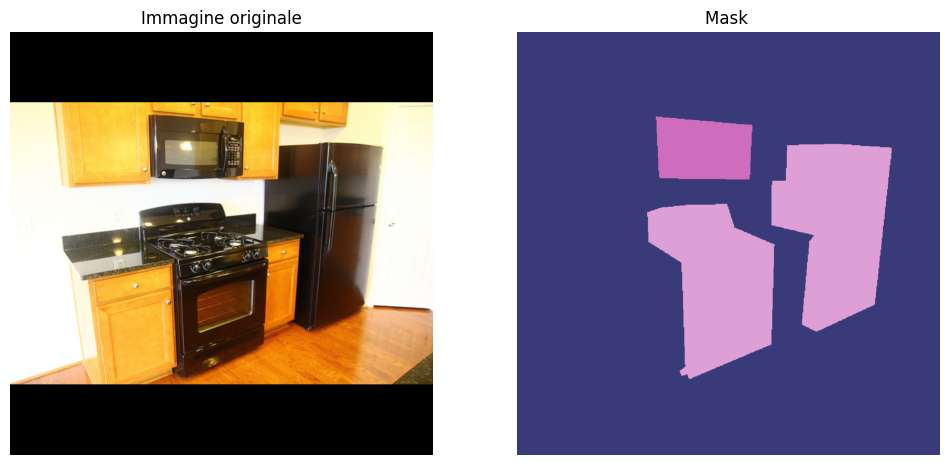

In [15]:
def show_gt_sample(dataset, idx):
    img, mask = dataset[idx]
    img_np = img.permute(1, 2, 0).numpy()

    num_classes = mask.max().item() + 1 

    # Colormap 
    cmap = plt.get_cmap("tab20b", num_classes) 
    mask_color = cmap(np.arange(num_classes) / (num_classes - 1))[:, :3] 
    mask_color = (mask_color * 255).astype(np.uint8)
    mask_color[1] = np.array([255, 0, 0], dtype=np.uint8) #Color-mask rossa per persone 
    mask_rgb = mask_color[mask.numpy()]

    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(img_np)
    plt.title("Immagine originale")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask_rgb)
    plt.title("Mask ")
    plt.axis("off")

    plt.show()


show_gt_sample(small_subset, random.randint(0, len(small_subset)-1))

In [16]:
# Model: FCN-ResNet50 from scratch
model = fcn_resnet50(weights=None, num_classes=NUM_CLASSES).to(DEVICE)

# Otimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

In [17]:
# 10 learning rate  tra 1e-3 e 1e-5

#lr_values = np.logspace(-2, -5, 10)
#print("Learning rates:", lr_values)
#results_train_loss = []
#results_val_loss = []

#for lr in lr_values:
    #print(f"  Addestramento completo con LR = {lr:.6e}")
    #model = fcn_resnet50(weights=None, num_classes=NUM_CLASSES).to(DEVICE)
    #optimizer = optim.Adam(model.parameters(), lr=lr)

    #best_train_loss = None
    #best_val_loss = None

    #for epoch in range(1, NUM_EPOCHS + 1):
        # TRAIN 

        #model.train()
        #running_train_loss = 0.0
        #pbar = tqdm(train_loader, desc=f"LR={lr:.1e} | Epoch {epoch}/{NUM_EPOCHS}")
        #for i, (imgs, masks) in enumerate(pbar, 1):
            #imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

            #optimizer.zero_grad()
            #outputs = model(imgs)["out"]
            #loss = criterion(outputs, masks)
            #loss.backward()
            #optimizer.step()

            #running_train_loss += loss.item()
            #avg_train_loss = running_train_loss / i
            #pbar.set_postfix(train_loss=f"{avg_train_loss:.4f}")

        #VALIDATION 

        #model.eval()
        #running_val_loss = 0.0
        #with torch.no_grad():
            #for imgs, masks in val_loader:
                #imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
                #outputs = model(imgs)["out"]
                #loss = criterion(outputs, masks)
                #running_val_loss += loss.item()

        #avg_val_loss = running_val_loss / len(val_loader)

        #print(f"Epoch {epoch}: train_loss={avg_train_loss:.4f}, val_loss={avg_val_loss:.4f}")

        # Salvataggio miglior loss lungo le epoche
        #if best_train_loss is None or avg_train_loss < best_train_loss:
         #   best_train_loss = avg_train_loss
        #if best_val_loss is None or avg_val_loss < best_val_loss:
         #   best_val_loss = avg_val_loss

    
    #results_train_loss.append(best_train_loss)
    #results_val_loss.append(best_val_loss)

    #print(f"--> LR={lr:.1e} | best_train_loss={best_train_loss:.4f}, best_val_loss={best_val_loss:.4f}")

    # libero memoria GPU prima di passare al prossimo LR
    #del model, optimizer
    #torch.cuda.empty_cache()

#plt.figure(figsize=(8,5))

#plt.semilogx(lr_values, results_val_loss, marker="o", label="Best Validation Loss")
#plt.semilogx(lr_values, results_train_loss, marker="x", linestyle="--", label="Best Train Loss")

#plt.xlabel("Learning Rate")
#plt.ylabel("Loss")
#plt.title("Sweep Learning Rate [1e-2, 1e-5]")
#plt.grid(True, which="both")
#plt.legend()
#plt.show()

In [18]:
train_losses = []
val_losses = []

best_val_loss = float("inf")

for epoch in range(NUM_EPOCHS):

    # Training
    model.train()
    running_train = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for i, (imgs, masks) in enumerate(pbar, 1):
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        out = model(imgs)["out"]
        loss = criterion(out, masks)
        loss.backward()
        optimizer.step()

        running_train += loss.item()
        pbar.set_postfix(loss=running_train / i)

    train_losses.append(running_train / len(train_loader))

    # Validation
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            out = model(imgs)["out"]
            loss = criterion(out, masks)
            running_val += loss.item()

    avg_val = running_val / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch+1} Train {train_losses[-1]:.4f}, Val {avg_val:.4f}")

    scheduler.step()

    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, "best_model.pth"))
        print("Salvato best model")

Epoch 1/20: 100%|██████████| 40/40 [00:44<00:00,  1.10s/it, loss=1.99]


Epoch 1 Train 1.9945, Val 1.1567
Salvato best model


Epoch 2/20: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.877]


Epoch 2 Train 0.8771, Val 0.9698
Salvato best model


Epoch 3/20: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.806]


Epoch 3 Train 0.8062, Val 0.9496
Salvato best model


Epoch 4/20: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.77] 


Epoch 4 Train 0.7696, Val 0.9170
Salvato best model


Epoch 5/20: 100%|██████████| 40/40 [00:42<00:00,  1.05s/it, loss=0.721]


Epoch 5 Train 0.7207, Val 0.9246


Epoch 6/20: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.661]


Epoch 6 Train 0.6611, Val 0.9443


Epoch 7/20: 100%|██████████| 40/40 [00:42<00:00,  1.05s/it, loss=0.678]


Epoch 7 Train 0.6785, Val 0.9738


Epoch 8/20: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.593]


Epoch 8 Train 0.5926, Val 0.9560


Epoch 9/20: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.544]


Epoch 9 Train 0.5437, Val 0.9066
Salvato best model


Epoch 10/20: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.496]


Epoch 10 Train 0.4957, Val 0.8750
Salvato best model


Epoch 11/20: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.474]


Epoch 11 Train 0.4741, Val 0.8965


Epoch 12/20: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.421]


Epoch 12 Train 0.4210, Val 0.9704


Epoch 13/20: 100%|██████████| 40/40 [00:42<00:00,  1.05s/it, loss=0.373]


Epoch 13 Train 0.3734, Val 0.8587
Salvato best model


Epoch 14/20: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.314]


Epoch 14 Train 0.3140, Val 0.8900


Epoch 15/20: 100%|██████████| 40/40 [00:42<00:00,  1.05s/it, loss=0.27] 


Epoch 15 Train 0.2698, Val 0.8691


Epoch 16/20: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.241]


Epoch 16 Train 0.2408, Val 0.9084


Epoch 17/20: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.222]


Epoch 17 Train 0.2216, Val 0.8773


Epoch 18/20: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.204]


Epoch 18 Train 0.2043, Val 0.8977


Epoch 19/20: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.195]


Epoch 19 Train 0.1950, Val 0.9090


Epoch 20/20: 100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.191]


Epoch 20 Train 0.1914, Val 0.9091


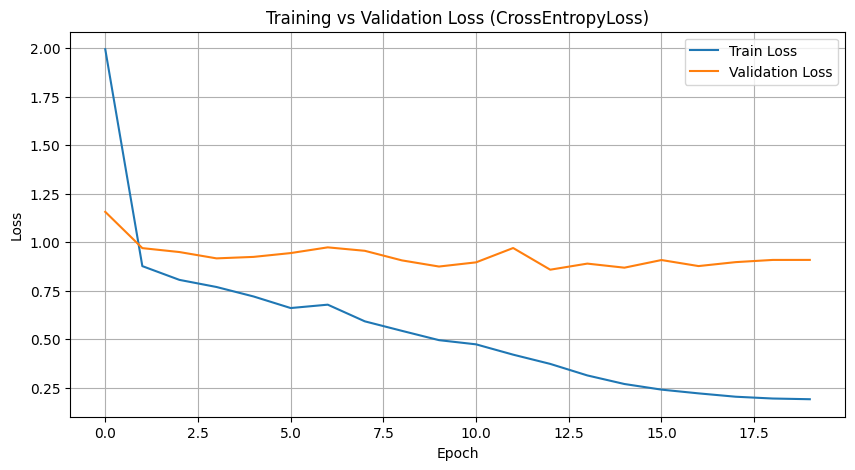

<Figure size 640x480 with 0 Axes>

Grafico salvato come: loss_plot_CrossEntropyLoss.png


In [19]:
#Grafico 
loss_name = criterion.__class__.__name__
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training vs Validation Loss ({loss_name})")
plt.legend()
plt.grid()
plt.show()

# Salvataggio dinamico in base alla loss

filename = f"loss_plot_{loss_name}.png"

plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

print(f"Grafico salvato come: {filename}")

In [20]:
#Risultati
#def pixel_acc(pred, gt):
#    valid = (gt >= 0)
#    return (pred[valid] == gt[valid]).sum().item() / valid.sum().item()
#
#model.eval()
#with torch.no_grad():
#    accs = []
#    for i in range(10):
#        img, gt = full_dataset[i]
#        inp = img.unsqueeze(0).to(DEVICE)
#        out = model(inp)["out"].argmax(1).squeeze(0).cpu()
#        accs.append(pixel_acc(out, gt))
#    print("Mean pixel accuracy (first 10):", float(np.mean(accs))

Figura salvata in: /kaggle/working/sample_16_loss_CrossEntropyLoss.png


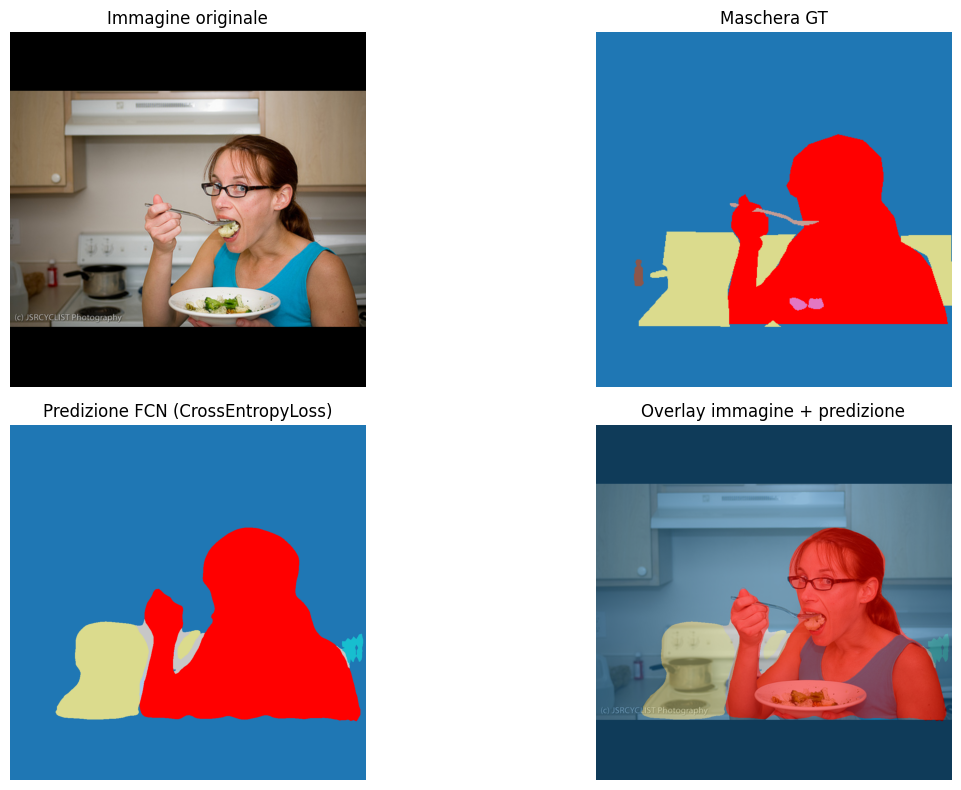

In [21]:
def visualize_sample(
    dataset,
    model,
    index=0,
    num_classes=NUM_CLASSES,
    person_class_index=1,
    save=True,
    out_dir="/kaggle/working"
):
    # Recupera nome della loss una sola volta
    loss_name = criterion.__class__.__name__

    model.eval()
    img, gt_mask = dataset[index]
    inp = img.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = model(inp)["out"].argmax(1).squeeze(0).cpu().numpy()

    img_np = img.permute(1, 2, 0).cpu().numpy()
    gt_np = gt_mask.numpy()

    # Colormap
    cmap_base = plt.get_cmap("tab20")
    mask_color = (cmap_base(np.arange(num_classes) / max(num_classes-1, 1))[:, :3] * 255).astype(np.uint8)
    if person_class_index < num_classes:
        mask_color[person_class_index] = np.array([255, 0, 0], dtype=np.uint8)

    def mask_to_rgb(mask):
        h, w = mask.shape
        rgb = np.zeros((h, w, 3), dtype=np.uint8)
        for i in range(num_classes):
            rgb[mask == i] = mask_color[i]
        return rgb

    gt_rgb = mask_to_rgb(gt_np)
    pred_rgb = mask_to_rgb(pred)

    plt.figure(figsize=(14, 8))

    plt.subplot(2, 2, 1)
    plt.imshow(img_np)
    plt.title("Immagine originale")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(gt_rgb)
    plt.title("Maschera GT")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(pred_rgb)
    plt.title(f"Predizione FCN ({loss_name})")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(img_np)
    plt.imshow(pred_rgb, alpha=0.5)
    plt.title("Overlay immagine + predizione")
    plt.axis("off")

    plt.tight_layout()

    # Salvataggio
    if save:
        filename = f"{out_dir}/sample_{index}_loss_{loss_name}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        print(f"Figura salvata in: {filename}")

    plt.show()

# Uso
index = random.randint(0, len(small_subset) - 1)
visualize_sample(small_subset, model, index)


📊 Calcolo IoU, F1 e Confusion Matrix (GPU, OOM-safe)…

===== RISULTATI FINALI =====
mIoU (macro su tutte le classi): 0.0366
F1-score (macro su tutte le classi): 0.0513

📈 IoU per classe:
Classe 0: IoU = 0.8580
Classe 1: IoU = 0.4605
Classe 2: IoU = 0.0000
Classe 3: IoU = 0.2839
Classe 4: IoU = 0.3580
Classe 5: IoU = 0.0000
Classe 6: IoU = 0.0000
Classe 7: IoU = 0.0000
Classe 8: IoU = 0.0000
Classe 9: IoU = 0.0000
Classe 10: IoU = 0.0000
Classe 11: IoU = 0.0000
Classe 12: IoU = 0.0000
Classe 13: IoU = 0.0000
Classe 14: IoU = 0.0000
Classe 15: IoU = 0.0000
Classe 16: IoU = 0.0000
Classe 17: IoU = 0.0000
Classe 18: IoU = 0.0000
Classe 19: IoU = 0.0000
Classe 20: IoU = 0.0000
Classe 21: IoU = 0.0000
Classe 22: IoU = 0.0000
Classe 23: IoU = 0.0000
Classe 24: IoU = 0.0000
Classe 25: IoU = 0.0000
Classe 26: IoU = 0.0000
Classe 27: IoU = 0.0000
Classe 28: IoU = 0.0000
Classe 29: IoU = 0.0000
Classe 30: IoU = 0.0000
Classe 31: IoU = 0.0000
Classe 32: IoU = 0.0000
Classe 33: IoU = 0.0000
Classe 

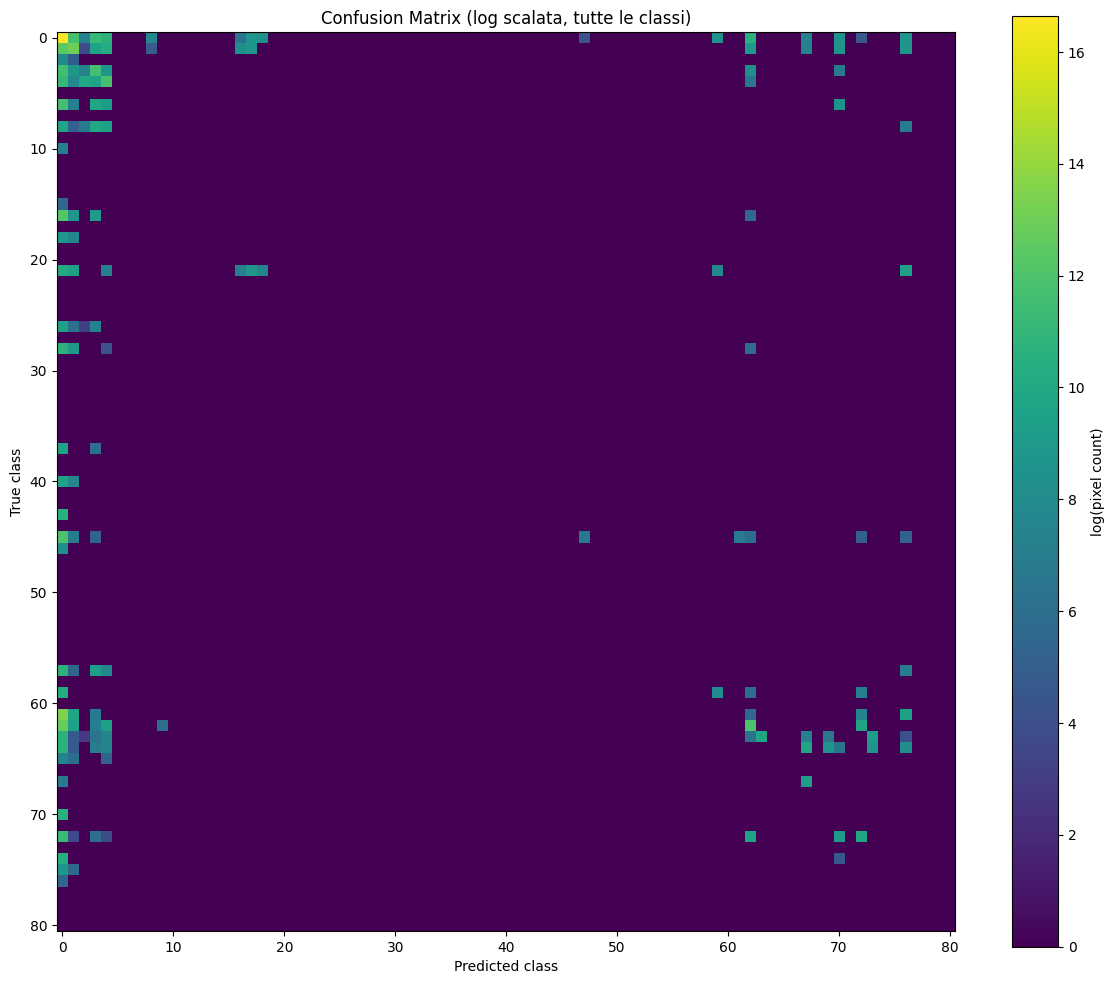

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt

print("📊 Calcolo IoU, F1 e Confusion Matrix (GPU, OOM-safe)…")

# --- CONTATORI GLOBALI ---
intersection = np.zeros(NUM_CLASSES, dtype=np.float64)
union        = np.zeros(NUM_CLASSES, dtype=np.float64)

TP = np.zeros(NUM_CLASSES, dtype=np.float64)
FP = np.zeros(NUM_CLASSES, dtype=np.float64)
FN = np.zeros(NUM_CLASSES, dtype=np.float64)

# Confusion matrix NUM_CLASSES × NUM_CLASSES
conf_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int64)

MAX_BATCHES = 150   # per non esplodere

model.eval()
with torch.no_grad():
    for batch_idx, (imgs, masks) in enumerate(val_loader):

        imgs  = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        logits = model(imgs)["out"]     # (B,C,H,W)
        preds  = logits.argmax(dim=1)   # (B,H,W)

        preds_np = preds.cpu().numpy().reshape(-1)
        masks_np = masks.cpu().numpy().reshape(-1)

        # --- Confusion Matrix update ---
        np.add.at(conf_matrix, (masks_np, preds_np), 1)

        # --- IoU ---
        for c in range(NUM_CLASSES):
            inter = np.sum((preds_np == c) & (masks_np == c))
            uni   = np.sum((preds_np == c) | (masks_np == c))
            intersection[c] += inter
            union[c]        += uni

        # --- F1 ---
        for c in range(NUM_CLASSES):
            TP[c] += np.sum((preds_np == c) & (masks_np == c))
            FP[c] += np.sum((preds_np == c) & (masks_np != c))
            FN[c] += np.sum((preds_np != c) & (masks_np == c))

        del logits, preds, imgs, masks

        if batch_idx >= MAX_BATCHES:
            break


# ----------------------
#     METRICHE FINALI
# ----------------------

# IoU per classe
IoU_perclass = intersection / (union + 1e-9)
mIoU = float(IoU_perclass.mean())   # MEDIA SU TUTTE LE CLASSI

# F1-score per classe
F1_perclass = (2 * TP) / (2 * TP + FP + FN + 1e-9)
F1_macro = float(F1_perclass.mean())   # MEDIA SU TUTTE LE CLASSI

print("\n===== RISULTATI FINALI =====")
print(f"mIoU (macro su tutte le classi): {mIoU:.4f}")
print(f"F1-score (macro su tutte le classi): {F1_macro:.4f}")

print("\n📈 IoU per classe:")
for i in range( NUM_CLASSES):
    print(f"Classe {i}: IoU = {IoU_perclass[i]:.4f}")

print("\n📈 F1 perclasse:")
for i in range( NUM_CLASSES):
    print(f"Classe {i}: F1 = {F1_perclass[i]:.4f}")

# -------------------------------------
# 🔥 GRAFICO DELLA CONFUSION MATRIX 🔥
# -------------------------------------

plt.figure(figsize=(12,10))
plt.imshow(np.log1p(conf_matrix), cmap="viridis")  # log per vedere meglio
plt.colorbar(label="log(pixel count)")
plt.title("Confusion Matrix (log scalata, tutte le classi)")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.tight_layout()
plt.show()


===== RISULTATI FINALI =====
mIoU (macro su tutte le classi): 0.0366
F1-score (macro su tutte le classi): 0.0513

📈 IoU per classe:
Classe 0: IoU = 0.8580
Classe 1: IoU = 0.4605
Classe 2: IoU = 0.0000
Classe 3: IoU = 0.2839
Classe 4: IoU = 0.3580
Classe 5: IoU = 0.0000
Classe 6: IoU = 0.0000
Classe 7: IoU = 0.0000
Classe 8: IoU = 0.0000
Classe 9: IoU = 0.0000
Classe 10: IoU = 0.0000
Classe 11: IoU = 0.0000
Classe 12: IoU = 0.0000
Classe 13: IoU = 0.0000
Classe 14: IoU = 0.0000
Classe 15: IoU = 0.0000
Classe 16: IoU = 0.0000
Classe 17: IoU = 0.0000
Classe 18: IoU = 0.0000
Classe 19: IoU = 0.0000
Classe 20: IoU = 0.0000
Classe 21: IoU = 0.0000
Classe 22: IoU = 0.0000
Classe 23: IoU = 0.0000
Classe 24: IoU = 0.0000
Classe 25: IoU = 0.0000
Classe 26: IoU = 0.0000
Classe 27: IoU = 0.0000
Classe 28: IoU = 0.0000
Classe 29: IoU = 0.0000
Classe 30: IoU = 0.0000
Classe 31: IoU = 0.0000
Classe 32: IoU = 0.0000
Classe 33: IoU = 0.0000
Classe 34: IoU = 0.0000
Classe 35: IoU = 0.0000
Classe 36: Io

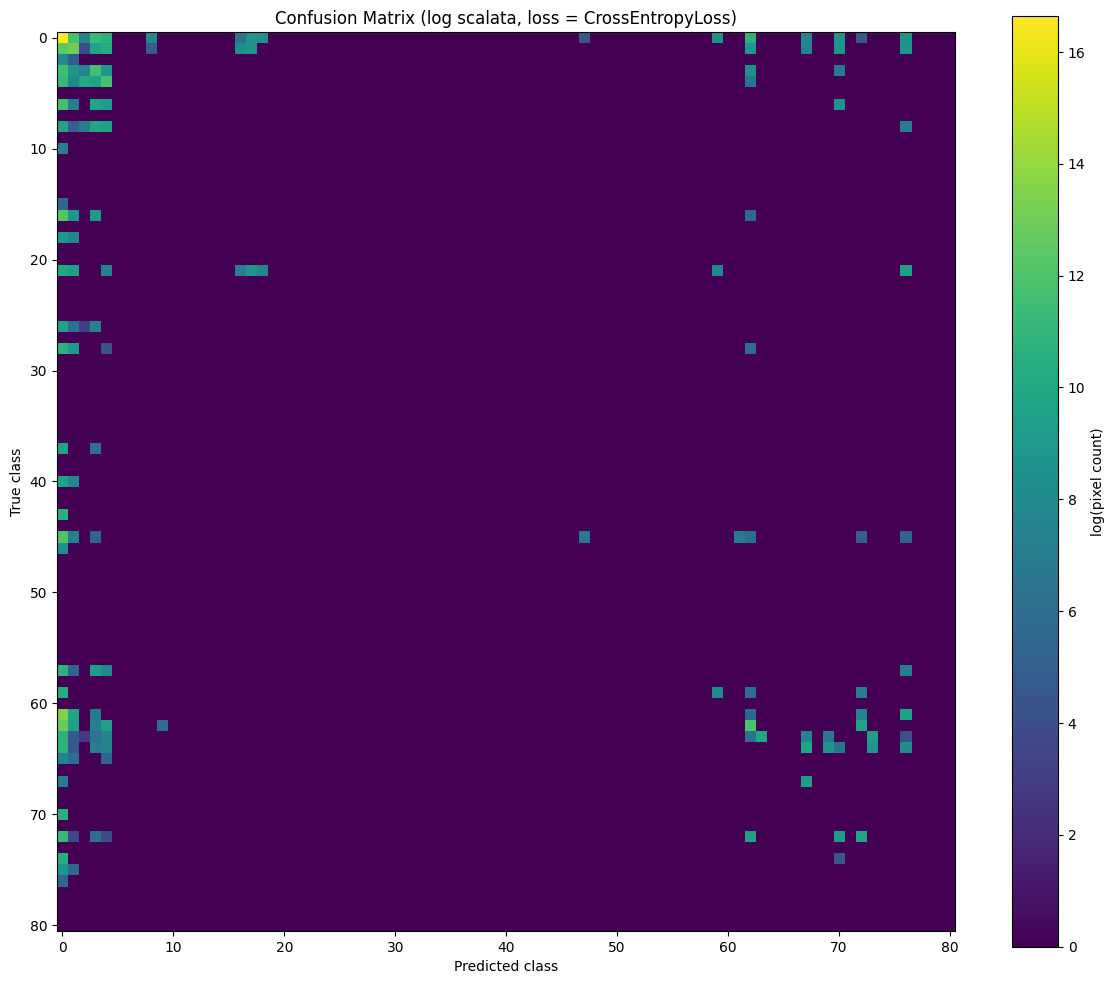

[Salvato] Istogramma macro (mIoU/F1): /kaggle/working/macro_metrics_CrossEntropyLoss.png


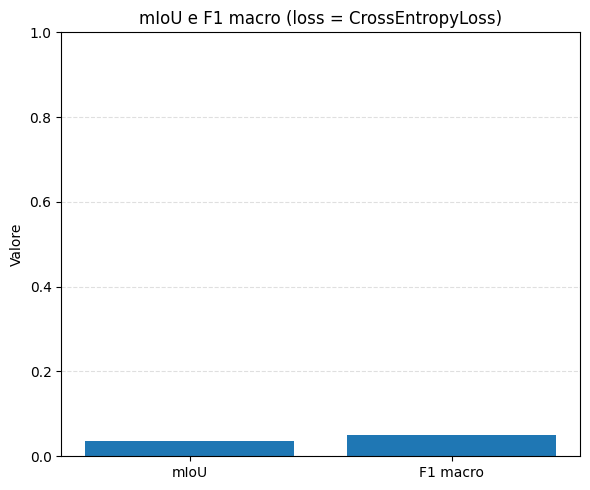

[Salvato] IoU per classe: /kaggle/working/IoU_per_class_CrossEntropyLoss.png


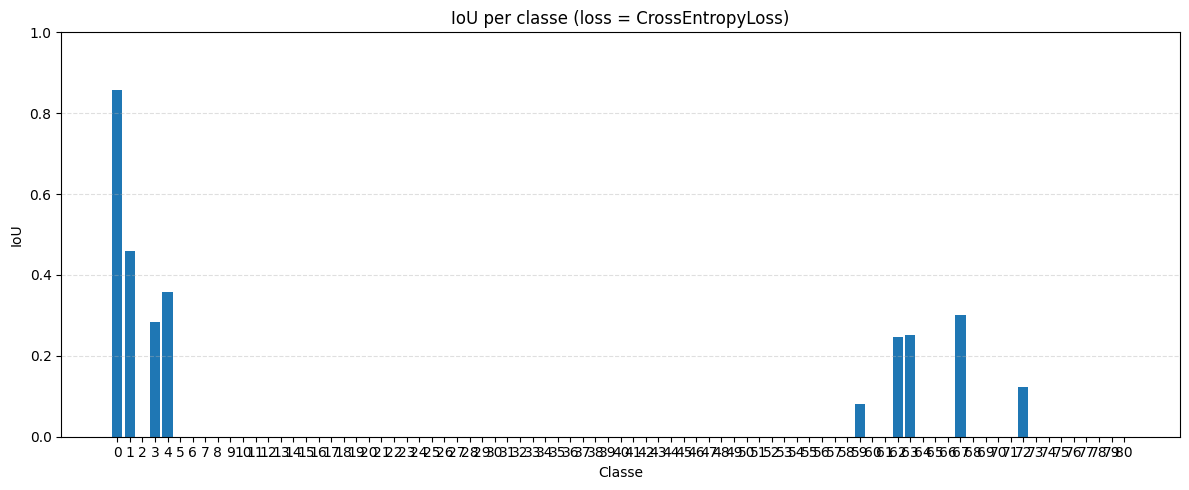

[Salvato] F1 per classe: /kaggle/working/F1_per_class_CrossEntropyLoss.png


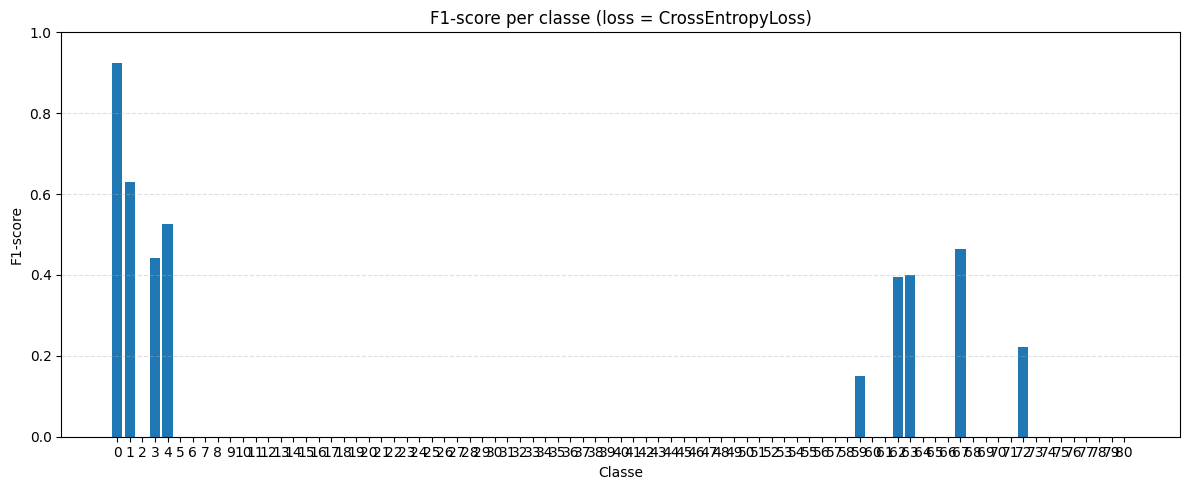

In [23]:
loss_name = criterion.__class__.__name__
# ----------------------
#     METRICHE FINALI
# ----------------------

# IoU per classe
IoU_perclass = intersection / (union + 1e-9)
mIoU = float(IoU_perclass.mean())   # MEDIA SU TUTTE LE CLASSI

# F1-score per classe
F1_perclass = (2 * TP) / (2 * TP + FP + FN + 1e-9)
F1_macro = float(F1_perclass.mean())   # MEDIA SU TUTTE LE CLASSI

# Nome della loss
loss_name = criterion.__class__.__name__

print("\n===== RISULTATI FINALI =====")
print(f"mIoU (macro su tutte le classi): {mIoU:.4f}")
print(f"F1-score (macro su tutte le classi): {F1_macro:.4f}")

print("\n📈 IoU per classe:")
for i in range(NUM_CLASSES):
    print(f"Classe {i}: IoU = {IoU_perclass[i]:.4f}")

print("\n📈 F1 per classe:")
for i in range(NUM_CLASSES):
    print(f"Classe {i}: F1 = {F1_perclass[i]:.4f}")

out_dir = "/kaggle/working"


# -------------------------------------
# 🔥 CONFUSION MATRIX CON NOME LOSS 🔥
# -------------------------------------

plt.figure(figsize=(12,10))
plt.imshow(np.log1p(conf_matrix), cmap="viridis")  # log per vedere meglio
plt.colorbar(label="log(pixel count)")
plt.title(f"Confusion Matrix (log scalata, loss = {loss_name})")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.tight_layout()

cm_path = f"{out_dir}/confusion_matrix_{loss_name}.png"
plt.savefig(cm_path, dpi=300, bbox_inches="tight")
print(f"\n[Salvato] Confusion matrix: {cm_path}")
plt.show()


# -------------------------------------
# 📊 ISTOGRAMMA mIoU vs F1 MACRO
# -------------------------------------

plt.figure(figsize=(6,5))
metrics_names = ["mIoU", "F1 macro"]
metrics_vals  = [mIoU, F1_macro]

plt.bar(metrics_names, metrics_vals)
plt.ylim(0, 1.0)
plt.ylabel("Valore")
plt.title(f"mIoU e F1 macro (loss = {loss_name})")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

macro_path = f"{out_dir}/macro_metrics_{loss_name}.png"
plt.savefig(macro_path, dpi=300, bbox_inches="tight")
print(f"[Salvato] Istogramma macro (mIoU/F1): {macro_path}")
plt.show()


# -------------------------------------
# 📊 ISTOGRAMMA IoU PER CLASSE
# -------------------------------------

plt.figure(figsize=(12,5))
x = np.arange(NUM_CLASSES)

plt.bar(x, IoU_perclass)
plt.xlabel("Classe")
plt.ylabel("IoU")
plt.title(f"IoU per classe (loss = {loss_name})")
plt.xticks(x)
plt.ylim(0, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

iou_path = f"{out_dir}/IoU_per_class_{loss_name}.png"
plt.savefig(iou_path, dpi=300, bbox_inches="tight")
print(f"[Salvato] IoU per classe: {iou_path}")
plt.show()


# -------------------------------------
# 📊 ISTOGRAMMA F1 PER CLASSE
# -------------------------------------

plt.figure(figsize=(12,5))
x = np.arange(NUM_CLASSES)

plt.bar(x, F1_perclass)
plt.xlabel("Classe")
plt.ylabel("F1-score")
plt.title(f"F1-score per classe (loss = {loss_name})")
plt.xticks(x)
plt.ylim(0, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

f1_path = f"{out_dir}/F1_per_class_{loss_name}.png"
plt.savefig(f1_path, dpi=300, bbox_inches="tight")
print(f"[Salvato] F1 per classe: {f1_path}")
plt.show()
